> Autor: Fabian Massotto

---

## Objetivo
Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: "focus_video.mov"

1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain" y realizar tres experimentos:
    - Medición sobre todo el frame.
    - Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.
    - Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)

    Para cada experimento se debe presentar :
    - Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto de máximo enfoque.
    - Video con la ROI o matriz, graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames donde se detecta la condición de máximo enfoque.

2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shapefrom focus.

El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática.

__Puntos extra__: Aplicar unsharp masking para expandir la zona de enfoque y devolver.

In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

video_path = 'video/focus_video.mov'

In [20]:
def image_quality_measure(image):
    # Convertimos la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Aplicamos la Transformada de Fourier
    f = np.fft.fft2(gray_image)
    
    # Shifteamos al centro
    fc = np.fft.fftshift(f)
    
    # Calculamos el valor absoluto de la transformada de Fourier centrada
    af = np.abs(fc)

    # Encontramos el valor máximo de los componentes de frecuencia
    m = np.max(af)
    
    # Calculamos el umbral y el número total de píxeles que superan el umbral
    thres = m / 1000
    th = np.sum(af > thres)

    # Paso 6: Calcular la métrica de calidad de imagen (FM)
    img_quality = th / (image.shape[0] * image.shape[1])
    
    return img_quality

In [9]:
# Función para obtener una frame específica del video
def get_frame(video, frame_number):
    captura_video = cv2.VideoCapture(video)
    frame = None

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
    else:
        if frame_number > captura_video.get(cv2.CAP_PROP_FRAME_COUNT):
            print("El frame indicado no existe")
        else:
            # Fijamos el frame indicado
            captura_video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        
            # Leer el frame específico
            ret, frame = captura_video.read()
    
    captura_video.release()
    cv2.destroyAllWindows()
    return frame

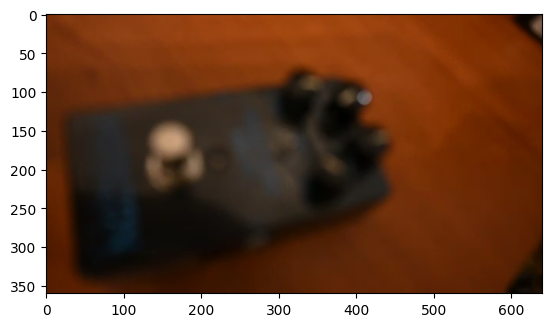

In [23]:
frame = get_frame(video_path, 0)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(1)
plt.imshow(frame)
plt.show()

In [24]:
print(image_quality_measure(frame))

0.007899305555555555


In [6]:
# Abre el video
video_path = 'video/focus_video.mov'
captura_video = cv2.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
        
    # Obtén la tasa de cuadros (frame rate) del video
    fps = int(captura_video.get(cv2.CAP_PROP_FPS))
    delay = int(1000 / fps)
    
    while True:
        ret, frame = captura_video.read()
        
        # Salir si termina el video
        if not ret:
            break
        
        # Mostrar el frame combinado
        cv2.imshow('Video Original y Blur Gaussiano', frame)
        
        # Salir del loop si se presiona la tecla 'q'
        if cv2.waitKey(delay) & 0xFF == ord('q'):
            break

# Libera el objeto de captura de video y cierra todas las ventanas
captura_video.release()
cv2.destroyAllWindows()

In [44]:
def coordenadas_cromaticas(img):
    new_img = []
    
    # Recorro cada pixel de la imagen
    for row in img:
        new_row = []
        for pixel in row:
            new_pixel = []
            red = pixel[0].astype(float)
            green = pixel[1].astype(float)
            blue = pixel[2].astype(float)
            
            # Sumo los valores de cada canal 
            ch_sum = red + green + blue
            
            # Chequeo si la suma da 0 para que no rompa el denominador
            if (ch_sum == 0):
                new_pixel = [0, 0, 0]
            
            # Divido cada canal por la suma
            else:
                new_pixel = [red/ch_sum, green/ch_sum, blue/ch_sum]

            new_row.append(new_pixel)
        
        new_img.append(new_row)

    # Observo los resultados
    comparar_imagenes(img, new_img, "Luego de aplicar coordenadas cromaticas")

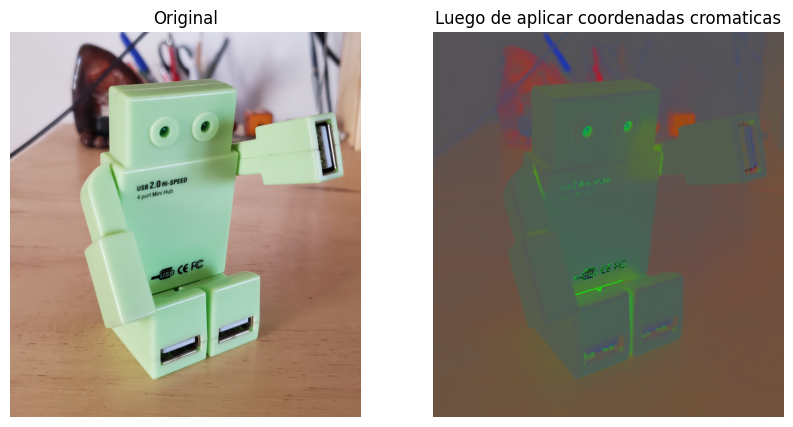

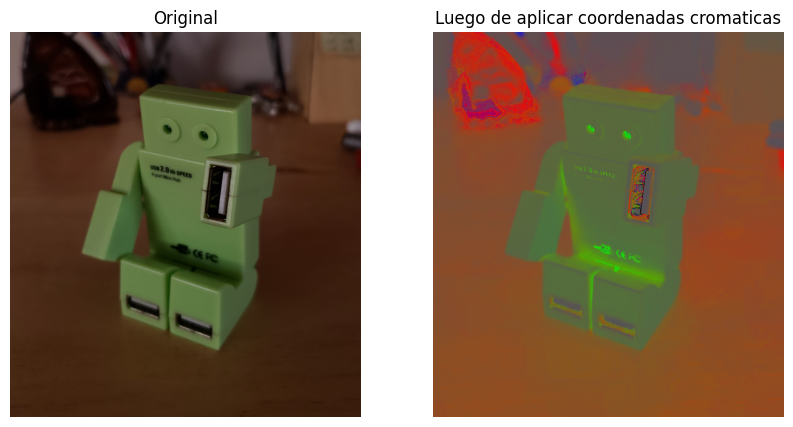

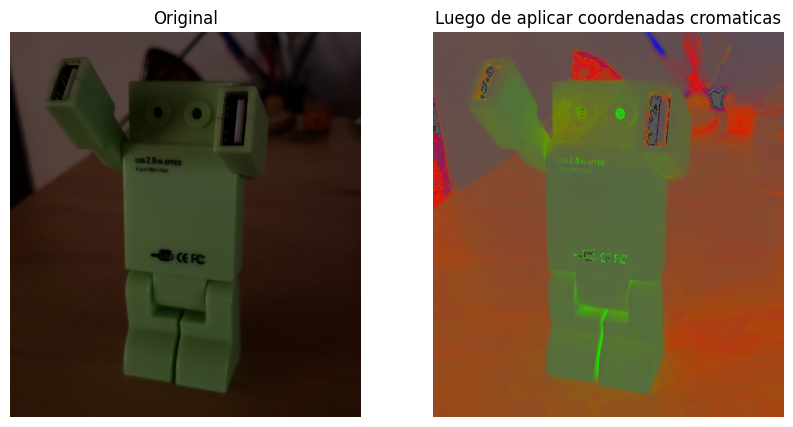

In [46]:
img1 = cv.cvtColor(cv.imread('coord_cromaticas/CoordCrom_1.png'), cv.COLOR_BGR2RGB)
coordenadas_cromaticas(img1)

img2 = cv.cvtColor(cv.imread('coord_cromaticas/CoordCrom_2.png'), cv.COLOR_BGR2RGB)
coordenadas_cromaticas(img2)

img3 = cv.cvtColor(cv.imread('coord_cromaticas/CoordCrom_3.png'), cv.COLOR_BGR2RGB)
coordenadas_cromaticas(img3)

In [85]:
def white_patch(img):
    new_img = []

    # Obtengo el maximo valor para cada canal
    channels = cv.split(img)
    red_max = np.max(channels[0])
    green_max = np.max(channels[1])
    blue_max = np.max(channels[2])

    print(f"Valores maximos: {red_max}, {green_max}, {blue_max}")

    # Si el maximo es 255 utilizo el percentil 95
    if red_max == 255:
        red_max = np.percentile(channels[0], 95)
    if green_max == 255:
        green_max = np.percentile(channels[1], 95)
    if blue_max == 255:
        blue_max = np.percentile(channels[2], 95)

    print(f"Valores perc 95: {red_max}, {green_max}, {blue_max}")
    
    # Recorro cada pixel de la imagen
    for row in img:
        new_row = []
        for pixel in row:
            new_pixel = []
            red = pixel[0].astype(float)
            green = pixel[1].astype(float)
            blue = pixel[2].astype(float)
            
            # Normalizamos al color de la luz blanca
            new_pixel = [red*255/red_max, green*255/green_max, blue*255/blue_max]
            new_pixel[0] = np.round(new_pixel[0],0).astype(np.uint8)
            new_pixel[1] = np.round(new_pixel[1],0).astype(np.uint8)
            new_pixel[2] = np.round(new_pixel[2],0).astype(np.uint8)

            new_row.append(new_pixel)
        
        new_img.append(new_row)

    # Observo los resultados
    comparar_imagenes(img, new_img, "Luego de aplicar white patch")

Valores maximos: 165, 138, 200
Valores perc 95: 165, 138, 200


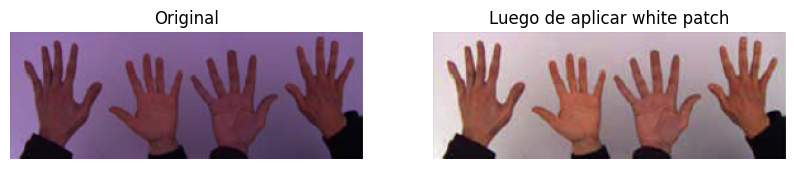

Valores maximos: 210, 250, 171
Valores perc 95: 210, 250, 171


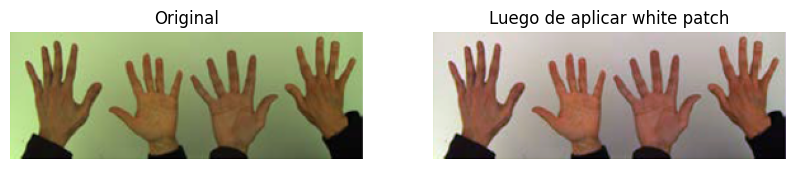

Valores maximos: 247, 157, 175
Valores perc 95: 247, 157, 175


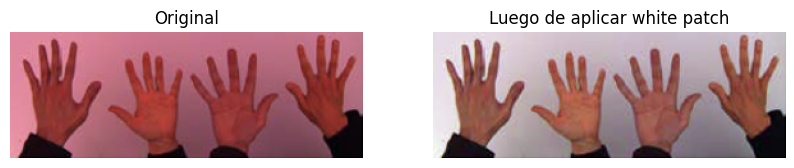

Valores maximos: 255, 255, 255
Valores perc 95: 56.0, 51.0, 252.0


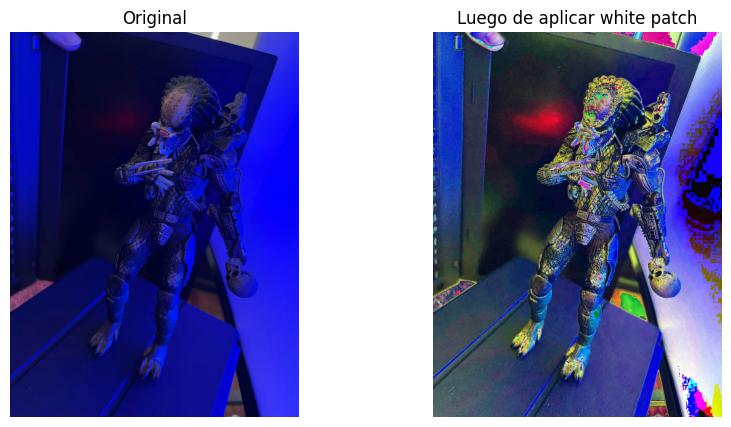

Valores maximos: 126, 252, 155
Valores perc 95: 126, 252, 155


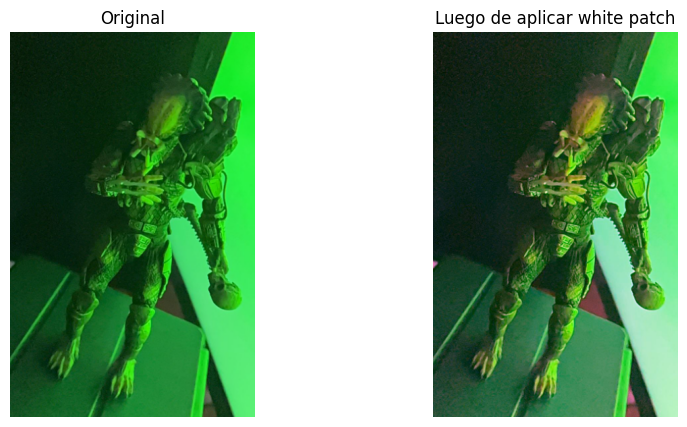

Valores maximos: 170, 255, 172
Valores perc 95: 170, 255.0, 172


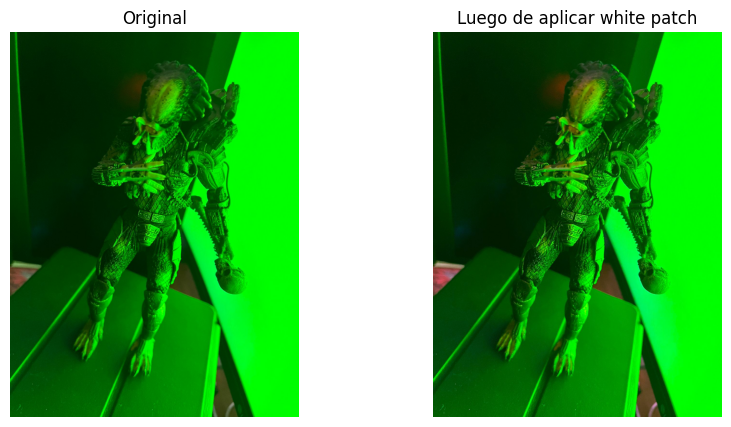

Valores maximos: 255, 134, 122
Valores perc 95: 255.0, 134, 122


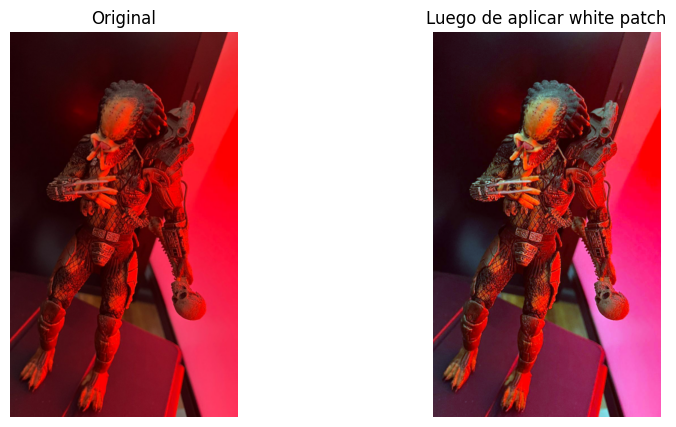

Valores maximos: 255, 201, 203
Valores perc 95: 255.0, 201, 203


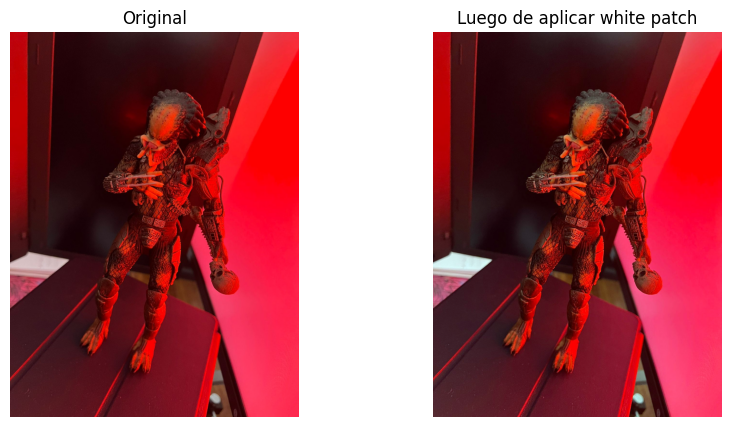

In [86]:
img1 = cv.cvtColor(cv.imread('white_patch/test_blue.png'), cv.COLOR_BGR2RGB)
white_patch(img1)

img2 = cv.cvtColor(cv.imread('white_patch/test_green.png'), cv.COLOR_BGR2RGB)
white_patch(img2)

img3 = cv.cvtColor(cv.imread('white_patch/test_red.png'), cv.COLOR_BGR2RGB)
white_patch(img3)

img4 = cv.cvtColor(cv.imread('white_patch/wp_blue.jpg'), cv.COLOR_BGR2RGB)
white_patch(img4)

img5 = cv.cvtColor(cv.imread('white_patch/wp_green.png'), cv.COLOR_BGR2RGB)
white_patch(img5)

img6 = cv.cvtColor(cv.imread('white_patch/wp_green2.jpg'), cv.COLOR_BGR2RGB)
white_patch(img6)

img7 = cv.cvtColor(cv.imread('white_patch/wp_red.png'), cv.COLOR_BGR2RGB)
white_patch(img7)

img8 = cv.cvtColor(cv.imread('white_patch/wp_red2.jpg'), cv.COLOR_BGR2RGB)
white_patch(img8)

#### Conclusiones

Se observa que en el caso del algoritmo White Patch, las fallas se presentan cuando los 3 canales de la imagen original tienen máximos de 255. Si no se considerara este caso, la imagen de salida sería idéntica a la imagen original. En este caso se tomó el percentil 95 en lugar del máximo, pero el resultado no es bueno debido a que para los canales rojo y verde, el percentil 95 está muy alejado del valor máximo.

### Parte 2

1. Para las imágenes img1_tp.png y img2_tp.png leerlas con OpenCV en escala de grises y visualizarlas.

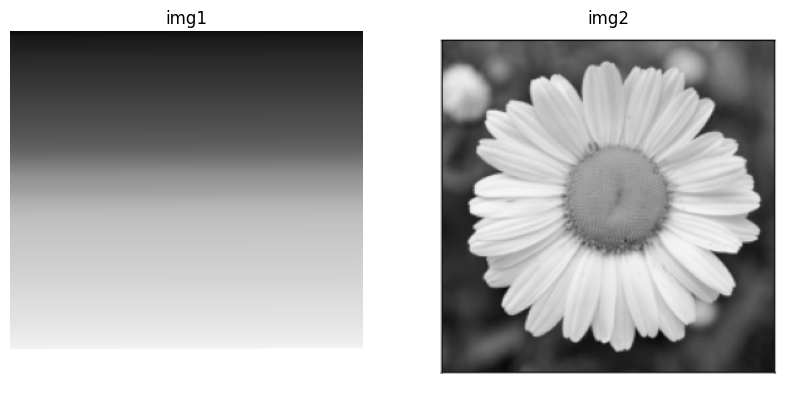

In [4]:
img1 = cv.imread('img1_tp.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('img2_tp.png', cv.IMREAD_GRAYSCALE)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img1, cmap="gray")
axes[0].axis('off')
axes[0].set_title('img1')
axes[1].imshow(img2, cmap="gray")
axes[1].axis('off')
axes[1].set_title('img2')
plt.show()

2. Elija el numero de bins que crea conveniente y grafique su histograma, compare los histogramas entre si. Explicar lo que se observa, si tuviera que entrenar un modelo de clasificación/detección de imágenes, considera que puede ser de utilidad tomar como 'features' a los histogramas?

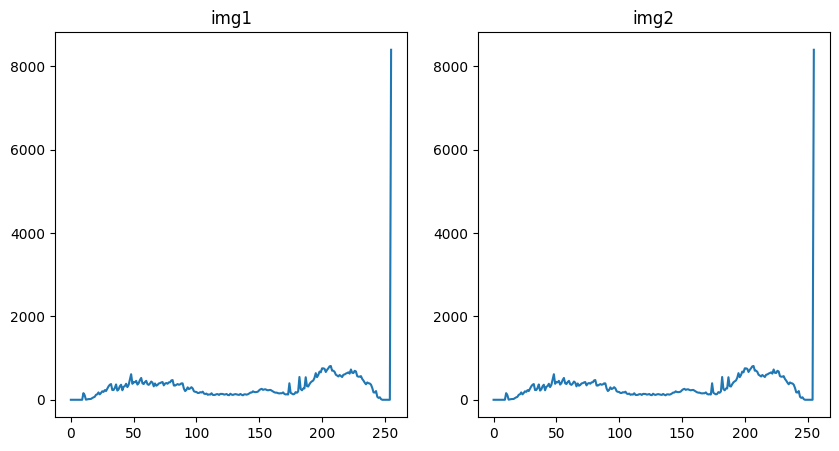

In [8]:
# Grafico los histogramas utilizando 256 bins para tener el detalle de cada tonalidad

hist1,bins1 = np.histogram(img1.ravel(),256,[0,256])
hist2,bins2 = np.histogram(img2.ravel(),256,[0,256])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(hist1)
axes[0].set_title('img1')
axes[1].plot(hist2)
axes[1].set_title('img2')
plt.show()

Observamos que ambos histogramas son muy similares o incluso idénticos, lo que indica que ambas imágenes tienen igual cantidad de píxeles para cada tonalidad. Observando únicamente los histogramas podríamos cometer el error de creer que las imágenes son similares, cuando en realidad claramente podemos distinguir que una corresponde a la foto de una flor, mientras que la otra es simplemente un degradé. Por lo tanto concluimos que los histogramas no serían de utilidad como features para un algoritmo de clasificación de imágenes.

3. Para la imagen segmentacion.png analice el histograma de los canales RGB. Segmente algunos de los elementos presentes en la imagen (agua, cielo, tierra) y muestre aplicando mascaras, las regiones en imágenes separadas.

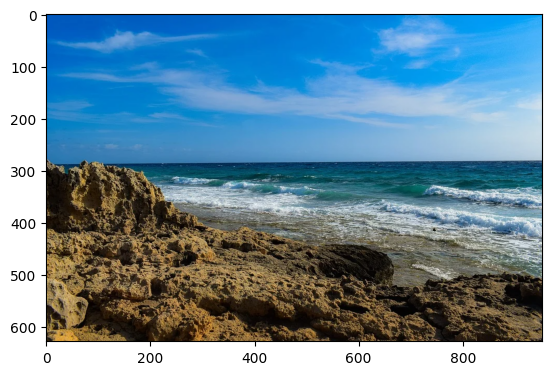

In [2]:
img = cv.cvtColor(cv.imread('segmentacion.png'), cv.COLOR_BGR2RGB)

plt.figure(1)
plt.imshow(img)
plt.show()

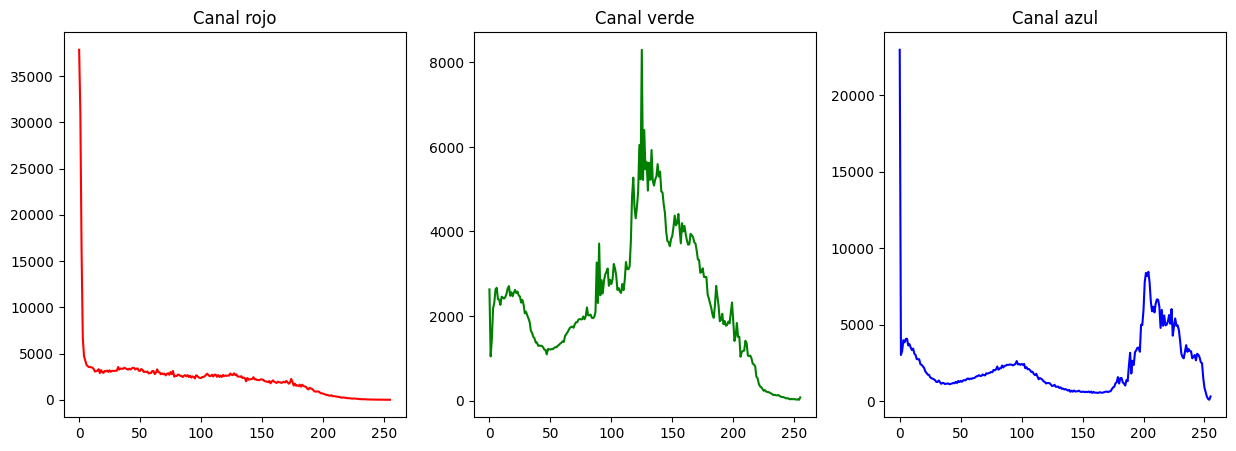

In [3]:
# Obtengo los canales
red, green, blue = cv.split(img)

# Calculo el histograma para cada canal
hist_red,bins_red = np.histogram(red.ravel(),256,[0,256])
hist_green,bins_green = np.histogram(green.ravel(),256,[0,256])
hist_blue,bins_blue = np.histogram(blue.ravel(),256,[0,256])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(hist_red, color="r")
axes[0].set_title('Canal rojo')
axes[1].plot(hist_green, color="g")
axes[1].set_title('Canal verde')
axes[2].plot(hist_blue, color='b')
axes[2].set_title('Canal azul')
plt.show()

Observaciones:
- Existe una alta concentración de valores altos para el canal azul, presumiblemente en la zona del cielo.
- También existe una gran cantidad de píxeles con valor cero para el canal azul, presumiblemente en la zona de la tierra.
- La gran mayoría de los píxeles tiene un valor de cero para el canal rojo.
- El histograma del canal verde presenta una especie de doble campana, donde la mayor parte de los pixeles presentan valores intermedios.

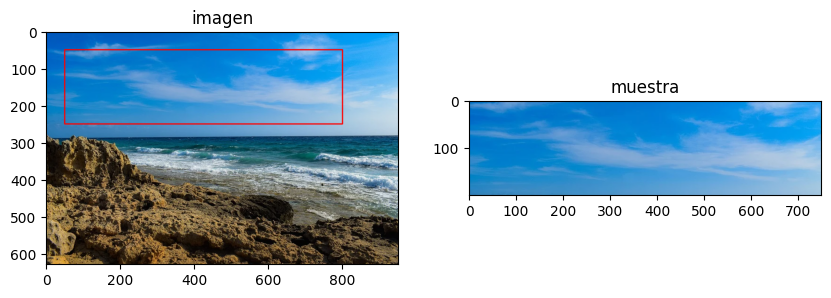

In [19]:
img_copy = img.copy()

# Tomamos una muestra del cielo
muestra_cielo = img[50:250, 50:800, :]
cv.rectangle(img_copy, (50,50), (800,250), (255,0,0), 2, cv.LINE_AA)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_copy)
axes[0].set_title('imagen')
axes[1].imshow(muestra_cielo)
axes[1].set_title('muestra')
plt.show()


Text(0.5, 1.0, 'mascara')

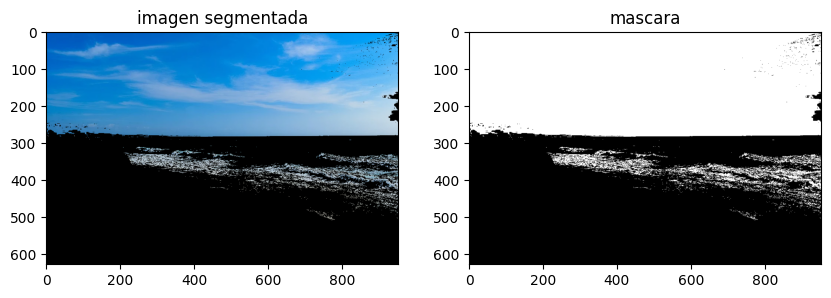

In [21]:
# Calculamos un modelo estadístico sencillo para caracterizar el color del cielo
color_mean, color_std = cv.meanStdDev(muestra_cielo)

# Creamos la mascara utilizando la media de la muestra +- n desvios estandar
n_sigma = 3
mask = cv.inRange(img, color_mean-color_std * n_sigma,  color_mean+color_std * n_sigma)
img_segmentada = cv.bitwise_and(img, img, mask=mask)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_segmentada)
axes[0].set_title('imagen segmentada')
axes[1].imshow(mask, cmap='gray')
axes[1].set_title('mascara')

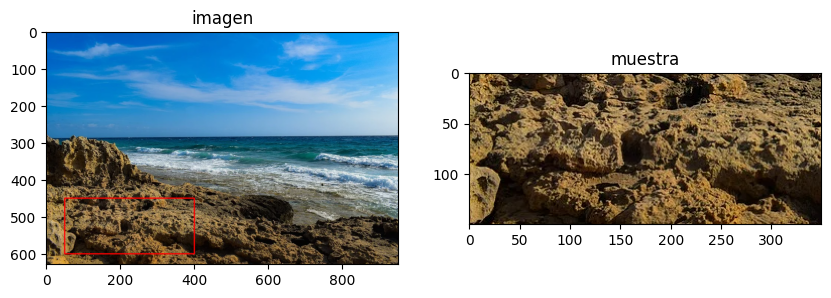

In [37]:
img_copy = img.copy()

# Tomamos una muestra de la tierra
muestra_tierra = img[450:600, 50:400, :]
cv.rectangle(img_copy, (50,450), (400,600), (255,0,0), 2, cv.LINE_AA)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_copy)
axes[0].set_title('imagen')
axes[1].imshow(muestra_tierra)
axes[1].set_title('muestra')
plt.show()

Text(0.5, 1.0, 'mascara')

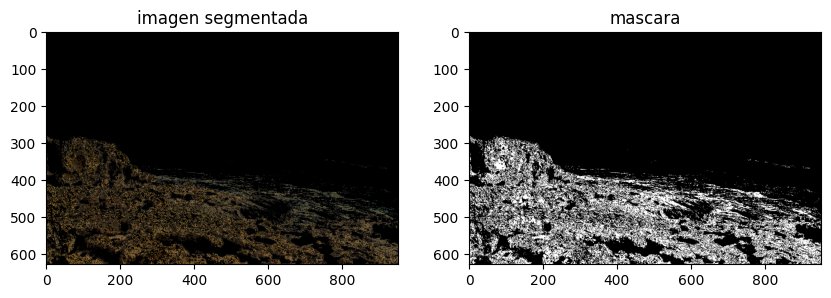

In [39]:
# Calculamos un modelo estadístico sencillo para caracterizar el color de la tierra
color_mean, color_std = cv.meanStdDev(muestra_tierra)

# Creamos la mascara utilizando la media de la muestra +- n desvios estandar
n_sigma = 1
mask = cv.inRange(img, color_mean-color_std * n_sigma,  color_mean+color_std * n_sigma)
img_segmentada = cv.bitwise_and(img, img, mask=mask)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_segmentada)
axes[0].set_title('imagen segmentada')
axes[1].imshow(mask, cmap='gray')
axes[1].set_title('mascara')

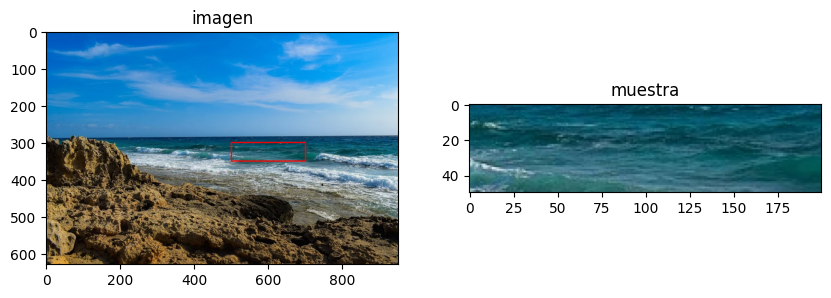

In [42]:
img_copy = img.copy()

# Tomamos una muestra del mar
muestra_mar = img[300:350, 500:700, :]
cv.rectangle(img_copy, (500,300), (700,350), (255,0,0), 2, cv.LINE_AA)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_copy)
axes[0].set_title('imagen')
axes[1].imshow(muestra_mar)
axes[1].set_title('muestra')
plt.show()

Text(0.5, 1.0, 'mascara')

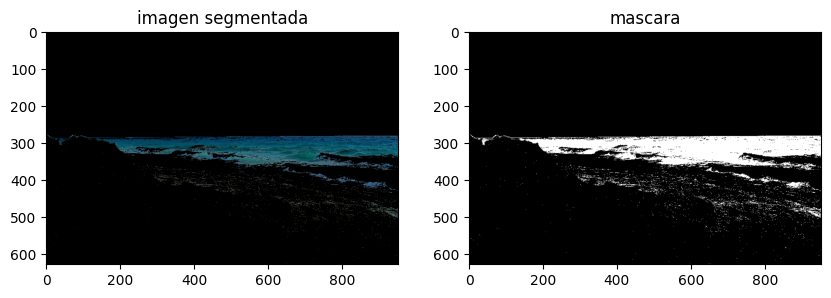

In [45]:
# Calculamos un modelo estadístico sencillo para caracterizar el color del mar
color_mean, color_std = cv.meanStdDev(muestra_mar)

# Creamos la mascara utilizando la media de la muestra +- n desvios estandar
n_sigma = 2
mask = cv.inRange(img, color_mean-color_std * n_sigma,  color_mean+color_std * n_sigma)
img_segmentada = cv.bitwise_and(img, img, mask=mask)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_segmentada)
axes[0].set_title('imagen segmentada')
axes[1].imshow(mask, cmap='gray')
axes[1].set_title('mascara')